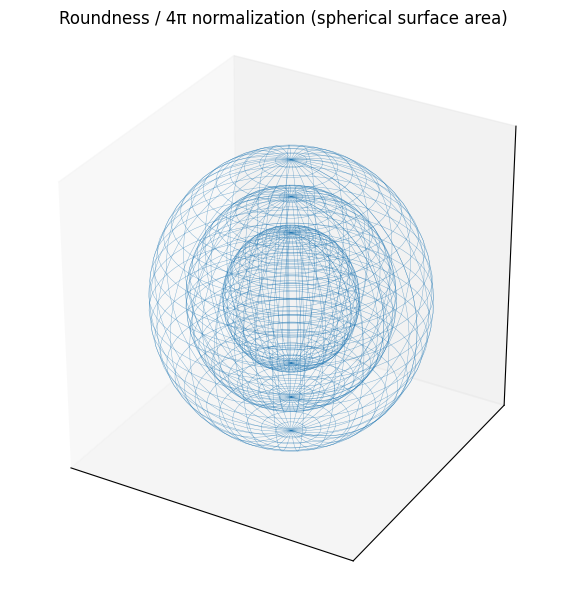

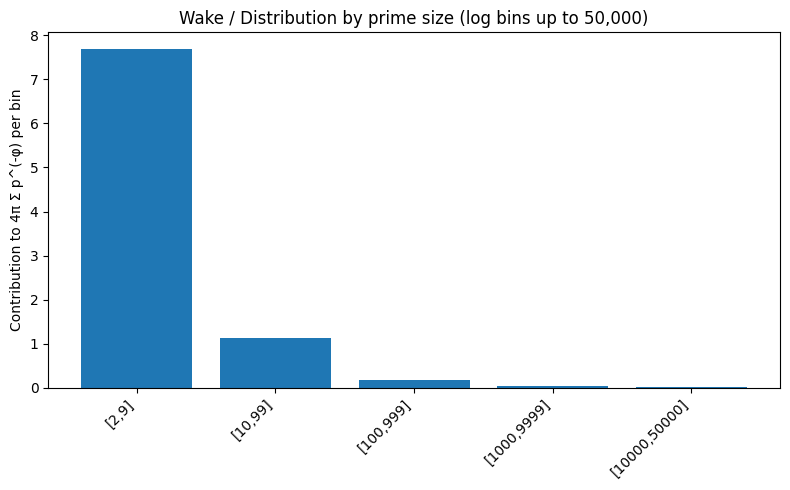

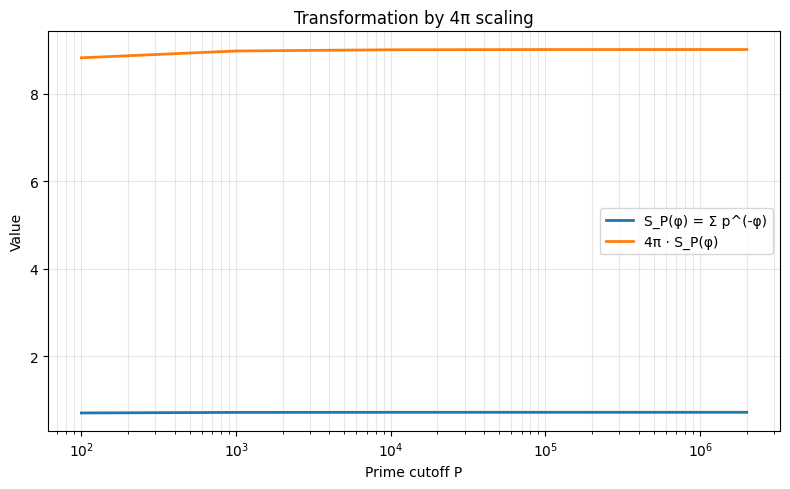

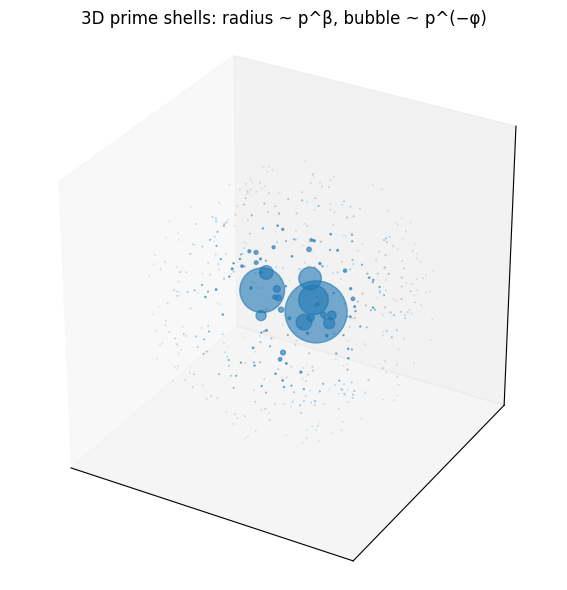

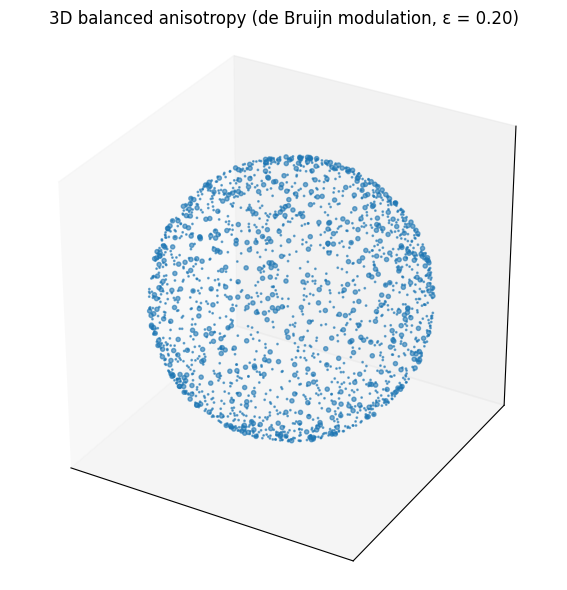

Saved:
  /content/fig1_roundness.png
  /content/fig2_wake_distribution.png
  /content/fig3_transformation.png
  /content/fig4_3d_shells_weights.png
  /content/fig5_3d_anisotropy.png


In [1]:
# === Five visuals for the Prime–Golden–Sphere story (Colab-safe) ===
# No LaTeX, no seaborn; one plot per figure; default colors only.

import math, time, random
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)
mp.mp.dps = 50

# -----------------------------
# Config
# -----------------------------
phi = (1 + 5**0.5) / 2
P_MAX = 2000000               # for S_P(phi)
BIN_P_MAX = 50000             # for wake/distribution bins (faster)
SHELL_P_COUNT = 500           # how many small primes to show in 3D shells
ANISO_P_COUNT = 2000          # for anisotropy cloud (indexing de Bruijn)
EPSILON = 0.20                # anisotropy strength for fig 5
DEBRUIJN_ORDER = 17           # B(2,n) length = 2^n (131072)

# -----------------------------
# Utilities
# -----------------------------
def sieve_primes(n):
    if n < 2: return []
    s = bytearray(b'\x01')*(n+1)
    s[0:2] = b'\x00\x00'
    m = int(n**0.5)
    for p in range(2, m+1):
        if s[p]:
            s[p*p:n+1:p] = b'\x00'*((n - p*p)//p + 1)
    return [i for i in range(n+1) if s[i]]

def partial_sum_phi(primes, upto):
    # 4π * sum_{p <= upto} p^{-phi}
    s = mp.mpf('0')
    for p in primes:
        if p > upto: break
        s += mp.power(p, -phi)
    return 4*mp.pi*s

def de_bruijn_binary(n):
    # returns a single cyclic B(2,n) as a list of 0/1 of length 2^n
    k = 2
    a = [0]*(k*n)
    seq = []
    def db(t, p):
        if t > n:
            if n % p == 0:
                seq.extend(a[1:p+1])
        else:
            a[t] = a[t-p]
            db(t+1, p)
            for j in range(a[t-p]+1, k):
                a[t] = j
                db(t+1, t)
    db(1,1)
    return seq  # length 2^n

def spherical_uniform(n):
    u = np.random.rand(n)
    v = np.random.rand(n)
    theta = 2*np.pi*u
    z = 2*v - 1
    rxy = np.sqrt(np.maximum(0.0, 1 - z*z))
    x = rxy*np.cos(theta); y = rxy*np.sin(theta)
    return np.column_stack([x,y,z])

# -----------------------------
# Data prep
# -----------------------------
primes_big = sieve_primes(P_MAX)
primes_bins = sieve_primes(BIN_P_MAX)
primes_small = primes_big[:SHELL_P_COUNT]

# For transformation curves
checkpoints = [10**2, 10**3, 10**4, 10**5, 10**6, 2*10**6]
fourpi_vals = []
S_vals = []
s_cum = mp.mpf('0'); i = 0
for p in primes_big:
    s_cum += mp.power(p, -phi)
    while i < len(checkpoints) and p > checkpoints[i]:
        fourpi_vals.append(4*mp.pi*s_cum)
        S_vals.append(s_cum)
        i += 1
# if last checkpoint equals last prime, values added; ensure equal length
while len(fourpi_vals) < len(checkpoints):
    fourpi_vals.append(4*mp.pi*s_cum); S_vals.append(s_cum)

# -----------------------------
# FIG 1 — Roundness (concentric spherical wireframes)
# -----------------------------
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
# Draw 3 concentric spheres with different radii
for r in [0.65, 1.0, 1.35]:
    u = np.linspace(0, 2*np.pi, 60)
    v = np.linspace(0, np.pi, 30)
    X = r*np.outer(np.cos(u), np.sin(v))
    Y = r*np.outer(np.sin(u), np.sin(v))
    Z = r*np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(X, Y, Z, linewidth=0.3, alpha=0.6)
ax.set_title("Roundness / 4π normalization (spherical surface area)")
ax.set_box_aspect([1,1,1])
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
plt.tight_layout()
f1 = "/content/fig1_roundness.png"
plt.savefig(f1, dpi=160, bbox_inches="tight"); plt.show()

# -----------------------------
# FIG 2 — Wake / Distribution (log-binned contributions)
# -----------------------------
# Bin primes by magnitude and sum contributions in each bin
bins = [10**k for k in range(1, int(math.log10(BIN_P_MAX))+1)]
bins.append(BIN_P_MAX+1)
bin_edges = [2] + bins
bin_sums = []
for a, b in zip(bin_edges[:-1], bin_edges[1:]):
    s = mp.mpf('0')
    for p in primes_bins:
        if a <= p < b:
            s += mp.power(p, -phi)
    bin_sums.append(float(4*mp.pi*s))
centers = [0.5*(a+b) for a,b in zip(bin_edges[:-1], bin_edges[1:])]

plt.figure(figsize=(8,5))
plt.bar(range(len(bin_sums)), bin_sums)
plt.xticks(range(len(bin_sums)),
           [f"[{bin_edges[i]},{bin_edges[i+1]-1}]" for i in range(len(bin_sums))],
           rotation=45, ha='right')
plt.ylabel("Contribution to 4π Σ p^(-φ) per bin")
plt.title("Wake / Distribution by prime size (log bins up to 50,000)")
plt.tight_layout()
f2 = "/content/fig2_wake_distribution.png"
plt.savefig(f2, dpi=160, bbox_inches="tight"); plt.show()

# -----------------------------
# FIG 3 — Transformation (S vs 4π·S across P)
# -----------------------------
plt.figure(figsize=(8,5))
xs = checkpoints
ys1 = [float(v) for v in S_vals]
ys2 = [float(v) for v in fourpi_vals]
plt.plot(xs, ys1, label="S_P(φ) = Σ p^(-φ)", linewidth=2)
plt.plot(xs, ys2, label="4π · S_P(φ)", linewidth=2)
plt.xscale("log"); plt.grid(True, which="both", alpha=0.3)
plt.xlabel("Prime cutoff P")
plt.ylabel("Value")
plt.title("Transformation by 4π scaling")
plt.legend()
plt.tight_layout()
f3 = "/content/fig3_transformation.png"
plt.savefig(f3, dpi=160, bbox_inches="tight"); plt.show()

# -----------------------------
# FIG 4 — 3D “prime shells” (r = p^β, size ~ p^{-φ})
# -----------------------------
beta = 0.22  # compress radii so points fit in frame
dirs = spherical_uniform(len(primes_small))
radii = np.array([float(p**beta) for p in primes_small])
radii = radii / (np.max(radii)) * 1.2  # normalize to ~1.2
sizes = np.array([float(p**(-phi)) for p in primes_small])
sizes = 2000 * sizes / np.max(sizes)   # scale bubble size

X = dirs[:,0]*radii; Y = dirs[:,1]*radii; Z = dirs[:,2]*radii
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, s=sizes, alpha=0.6, depthshade=True)
ax.set_title("3D prime shells: radius ~ p^β, bubble ~ p^(−φ)")
ax.set_box_aspect([1,1,1])
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
plt.tight_layout()
f4 = "/content/fig4_3d_shells_weights.png"
plt.savefig(f4, dpi=160, bbox_inches="tight"); plt.show()

# -----------------------------
# FIG 5 — 3D “balanced anisotropy” (de Bruijn modulation)
# -----------------------------
B = de_bruijn_binary(DEBRUIJN_ORDER)
period = len(B)
M = np.array([1 if b==1 else -1 for b in B], dtype=np.int8)

# Use a larger set of random directions; modulate size by (1 + ε m_k)
dirs2 = spherical_uniform(ANISO_P_COUNT)
idx = np.arange(ANISO_P_COUNT) % period
mvals = M[idx].astype(float)
amp = 1.0 + EPSILON * mvals   # balanced (zero-mean) anisotropy
# Put all points on unit sphere; vary size by amp
sizes2 = 20.0 * (amp - np.min(amp) + 0.05)  # always positive

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dirs2[:,0], dirs2[:,1], dirs2[:,2], s=sizes2, alpha=0.6, depthshade=True)
ax.set_title("3D balanced anisotropy (de Bruijn modulation, ε = %.2f)" % EPSILON)
ax.set_box_aspect([1,1,1])
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
plt.tight_layout()
f5 = "/content/fig5_3d_anisotropy.png"
plt.savefig(f5, dpi=160, bbox_inches="tight"); plt.show()

print("Saved:")
print(" ", f1)
print(" ", f2)
print(" ", f3)
print(" ", f4)
print(" ", f5)
